In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

Redefine the network

In [2]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Load the saved network

In [3]:
maskgen=UNet(n_channels=1, n_classes=1)
maskgen.load_state_dict(torch.load("./Segnet.pth"))
maskgen.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

Files to be processed. You need to prepare the folders to save (for safety not to overwrite anything).

In [4]:
fromfiles=["./data/raw/allimages-r-184.npy","./data/raw/allimages-r-153.npy","./data/raw/allimages-r-137.npy"]
todir=["./data/mask/184/","./data/mask/153/","./data/mask/137/"]

Process all files

In [5]:
for i,(filename,dirname) in enumerate(zip(fromfiles,todir)):
    print("File",str(i))
    allimages=np.load(filename)
    masks=[]
    maskeds=[]
    for j,im in enumerate(allimages):
        print("\r Timeslice: "+str(j),end="")
        predicted=maskgen(torch.Tensor(np.mean(im,axis=2)).unsqueeze(0).unsqueeze(0)).detach().numpy()[0,0,:,:]
        masks.append(predicted)
        #print(((predicted>0.5)[:,:,None]&im).shape)
        maskeds.append((predicted>0.5)[:,:,None]*im)
    print("Saving")
    np.save(dirname+"masks_v1.5",masks)
    np.save(dirname+"maskeds0.5_v1.5",maskeds)

File 0
 Timeslice: 3001Saving
File 1
 Timeslice: 3475Saving
File 2
 Timeslice: 1512Saving


Some frames can be tested

In [4]:
allimagesr=np.load("./data/raw/allimages-r-184.npy")

In [5]:
allimagesr2=np.load("./data/raw/allimages-r-137.npy")



In [6]:
t=np.random.randint(0,len(allimagesr))

In [7]:
predicted=maskgen(torch.Tensor(np.mean(allimagesr[t],axis=2)).unsqueeze(0).unsqueeze(0)).detach().numpy()[0,0,:,:]

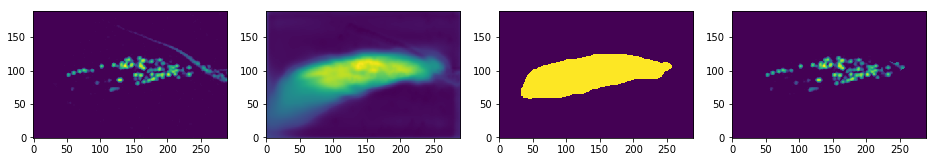

In [8]:
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(np.log(np.mean(allimagesr[t],axis=2)+1).T,origin="below")
plt.subplot(142)
plt.imshow(predicted.T,origin="below")
plt.subplot(143)
plt.imshow(predicted.T>0.5,origin="below")
plt.subplot(144)
plt.imshow((predicted.T>0.5)*np.log(np.mean(allimagesr[t],axis=2)+1).T,origin="below")

In [9]:
t=np.random.randint(0,len(allimagesr2))
predicted2=maskgen(torch.Tensor(np.mean(allimagesr2[t],axis=2)).unsqueeze(0).unsqueeze(0)).detach().numpy()[0,0,:,:]

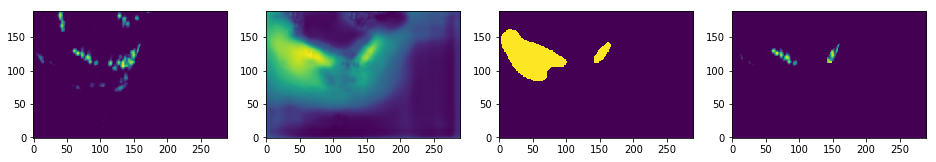

In [10]:
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.imshow(np.log(np.mean(allimagesr2[t],axis=2)+1).T,origin="below")
plt.subplot(142)
plt.imshow(predicted2.T,origin="below")
plt.subplot(143)
plt.imshow(predicted2.T>0.5,origin="below")
plt.subplot(144)
plt.imshow((predicted2.T>0.5)*np.log(np.mean(allimagesr2[t],axis=2)+1).T,origin="below")